In [1]:
from sklearn.datasets import fetch_covtype
import pandas as pd

# Load the dataset
covtype = fetch_covtype(as_frame=True)  # Returns a DataFrame
X = covtype.data  # Features
y = covtype.target - 1  # Target (adjusted to 0-6 for zero-based indexing)

In [2]:
sample_size = 20000
# Ensure we get a balanced sample across all classes
from sklearn.model_selection import train_test_split
X_sample, _, y_sample, _ = train_test_split(
    X, y, train_size=sample_size, random_state=42, stratify=y
)
X = X_sample
y = y_sample

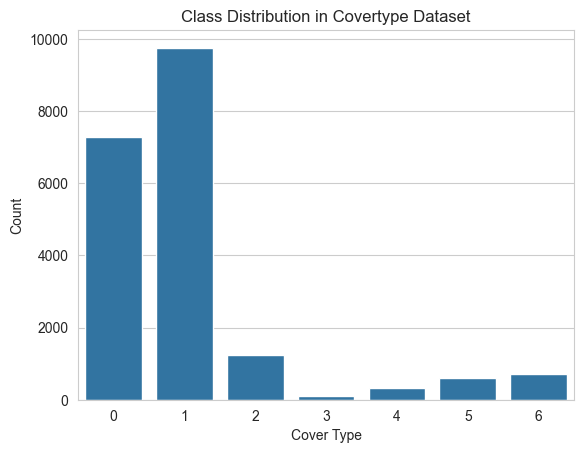

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x=y)
plt.title('Class Distribution in Covertype Dataset')
plt.xlabel('Cover Type')
plt.ylabel('Count')
plt.show()

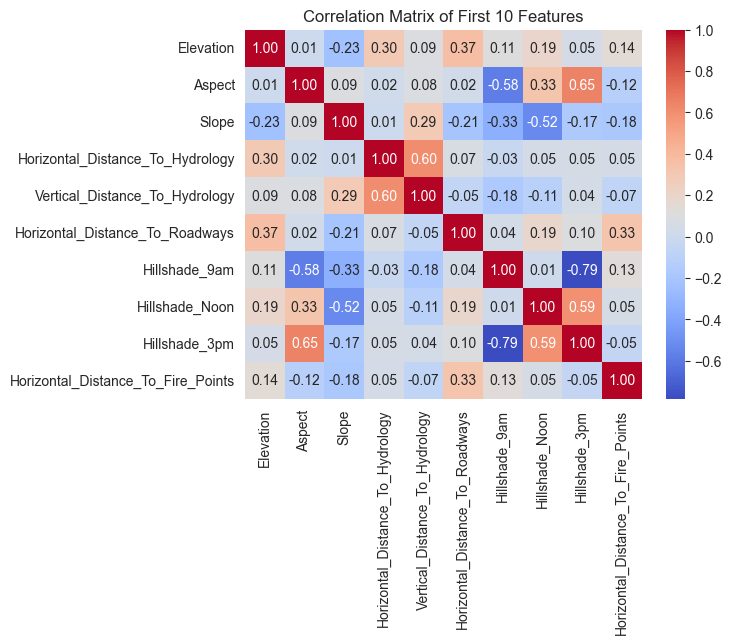

In [4]:
# Select first 10 features for simplicity
subset = X.iloc[:, :10]

# Compute correlation matrix
corr = subset.corr()

# Plot heatmap
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of First 10 Features')
plt.show()

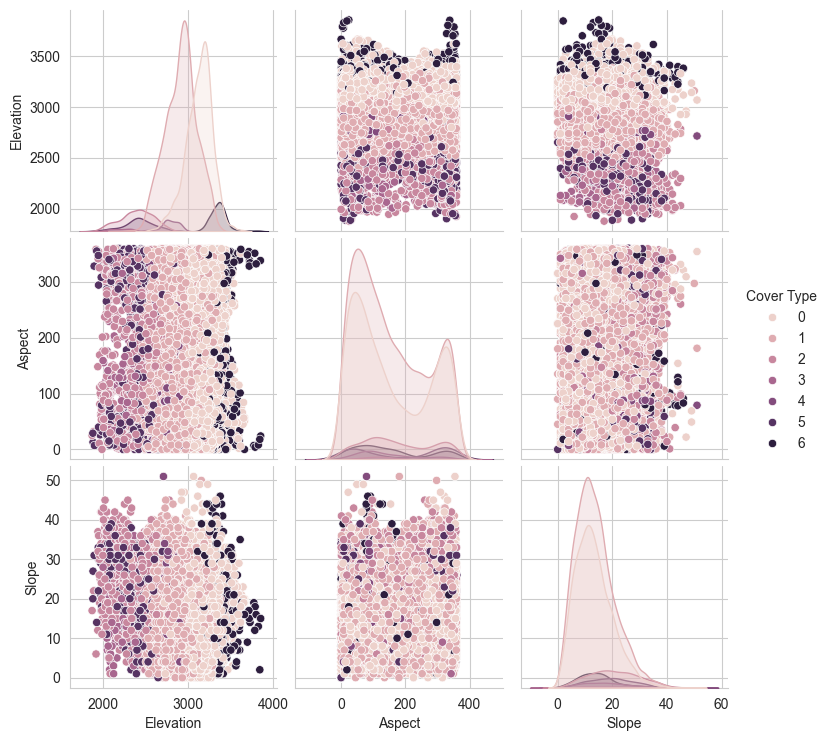

In [5]:
# Combine features and target for a sample
sample = X.iloc[:, :3].copy()  # First 3 features
sample['Cover Type'] = y

sns.pairplot(sample, hue='Cover Type', diag_kind='kde')
plt.show()

In [6]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Split the dataset into training, validation and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Initialize the CatBoost model with default settings
model = CatBoostClassifier(verbose=0, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate accuracy
baseline_accuracy = accuracy_score(y_test, y_pred)

print(f"Baseline Accuracy: {baseline_accuracy * 100:.2f}%")

Baseline Accuracy: 83.43%


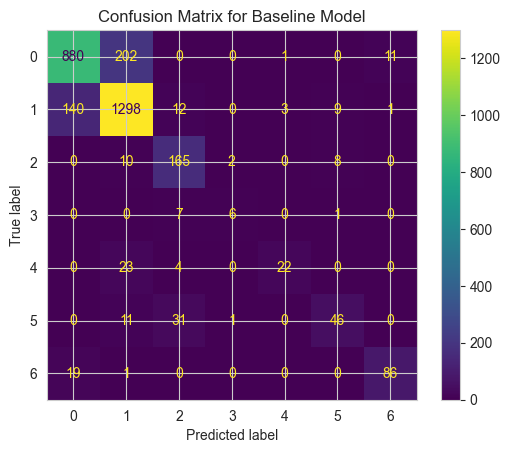

In [7]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)
plt.title('Confusion Matrix for Baseline Model')
plt.show()

In [8]:
from catboost.utils import get_gpu_device_count

gpu_count = get_gpu_device_count()
if gpu_count > 0:
    print(f"GPU is available. {gpu_count} GPU(s) detected.")
else:
    print("GPU is NOT available.")

GPU is available. 1 GPU(s) detected.


In [10]:
import numpy as np
import optuna
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score


def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'depth': trial.suggest_int('depth', 4, 12),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10.0, log=True),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'random_strength': trial.suggest_float('random_strength', 1e-3, 10.0, log=True),
        'verbose' : 50,
        'task_type': 'GPU',
        
    }
    
    model = CatBoostClassifier(**params)
    model.fit(X_train, y_train)
    
    preds = model.predict(X_valid)
    accuracy = accuracy_score(y_valid, preds)
    
    return accuracy

After first 20 trials I am changing max limit of depth, bagging_temperature and random_strength to higher values because they were hitting the boundaries

In [11]:
# Create the study
study_name = 'catboost_optimization'
storage_name = 'sqlite:///example.db'
study = optuna.create_study(
    study_name=study_name,
    storage=storage_name,
    direction='maximize',
    load_if_exists=True
)
study.optimize(objective, n_trials=20)  # Run 20 trials

[I 2025-04-17 03:15:39,857] A new study created in RDB with name: catboost_optimization


0:	learn: 1.9058018	total: 29.2ms	remaining: 11.3s
50:	learn: 1.0941464	total: 525ms	remaining: 3.46s
100:	learn: 0.8559767	total: 1.29s	remaining: 3.67s
150:	learn: 0.7442144	total: 2.07s	remaining: 3.24s
200:	learn: 0.6854180	total: 2.82s	remaining: 2.61s
250:	learn: 0.6480111	total: 3.39s	remaining: 1.83s
300:	learn: 0.6221528	total: 4.32s	remaining: 1.23s
350:	learn: 0.6017091	total: 4.96s	remaining: 509ms


[I 2025-04-17 03:15:46,248] Trial 0 finished with value: 0.7603333333333333 and parameters: {'iterations': 387, 'learning_rate': 0.01407051532602968, 'depth': 6, 'l2_leaf_reg': 1.1547404716192802, 'border_count': 236, 'bagging_temperature': 0.6909501502950927, 'random_strength': 0.005757832522742387}. Best is trial 0 with value: 0.7603333333333333.


386:	learn: 0.5893910	total: 5.34s	remaining: 0us
0:	learn: 1.3869894	total: 23.3ms	remaining: 9.38s
50:	learn: 0.4559746	total: 1.22s	remaining: 8.41s
100:	learn: 0.3708132	total: 2.12s	remaining: 6.33s
150:	learn: 0.3157943	total: 3.22s	remaining: 5.37s
200:	learn: 0.2773721	total: 4.24s	remaining: 4.26s
250:	learn: 0.2445189	total: 5.25s	remaining: 3.18s
300:	learn: 0.2182735	total: 6.23s	remaining: 2.11s
350:	learn: 0.1951024	total: 8.88s	remaining: 1.31s
400:	learn: 0.1754818	total: 9.98s	remaining: 49.8ms
402:	learn: 0.1744307	total: 10s	remaining: 0us


[I 2025-04-17 03:15:56,897] Trial 1 finished with value: 0.8406666666666667 and parameters: {'iterations': 403, 'learning_rate': 0.23329251701993997, 'depth': 8, 'l2_leaf_reg': 4.643630565113606, 'border_count': 104, 'bagging_temperature': 0.9486367556884518, 'random_strength': 0.012241053503155021}. Best is trial 1 with value: 0.8406666666666667.


0:	learn: 1.8564796	total: 13.9ms	remaining: 8.03s
50:	learn: 0.7992780	total: 723ms	remaining: 7.48s
100:	learn: 0.6333895	total: 1.38s	remaining: 6.53s
150:	learn: 0.5680987	total: 2.04s	remaining: 5.79s
200:	learn: 0.5276553	total: 3.17s	remaining: 5.96s
250:	learn: 0.4958931	total: 3.93s	remaining: 5.13s
300:	learn: 0.4705536	total: 4.73s	remaining: 4.37s
350:	learn: 0.4496589	total: 5.47s	remaining: 3.55s
400:	learn: 0.4320319	total: 6.28s	remaining: 2.79s
450:	learn: 0.4161410	total: 7.46s	remaining: 2.12s
500:	learn: 0.4016785	total: 8.34s	remaining: 1.3s
550:	learn: 0.3879845	total: 9.03s	remaining: 459ms


[I 2025-04-17 03:16:07,094] Trial 2 finished with value: 0.813 and parameters: {'iterations': 579, 'learning_rate': 0.030964595237588752, 'depth': 7, 'l2_leaf_reg': 0.4217478566981357, 'border_count': 204, 'bagging_temperature': 0.8540033826874514, 'random_strength': 0.009124579820340333}. Best is trial 1 with value: 0.8406666666666667.


578:	learn: 0.3802980	total: 9.59s	remaining: 0us
0:	learn: 1.6100342	total: 126ms	remaining: 1m 34s
50:	learn: 0.2874615	total: 6.76s	remaining: 1m 33s
100:	learn: 0.1623150	total: 12.7s	remaining: 1m 21s
150:	learn: 0.1009041	total: 18.7s	remaining: 1m 14s
200:	learn: 0.0651830	total: 24.5s	remaining: 1m 7s
250:	learn: 0.0423526	total: 31.5s	remaining: 1m 3s
300:	learn: 0.0291523	total: 39s	remaining: 58.6s
350:	learn: 0.0199495	total: 44.9s	remaining: 51.4s
400:	learn: 0.0138415	total: 50.7s	remaining: 44.5s
450:	learn: 0.0095159	total: 57s	remaining: 38.1s
500:	learn: 0.0066309	total: 1m 2s	remaining: 31.5s
550:	learn: 0.0046840	total: 1m 8s	remaining: 25s
600:	learn: 0.0033162	total: 1m 13s	remaining: 18.6s
650:	learn: 0.0023125	total: 1m 19s	remaining: 12.4s
700:	learn: 0.0017262	total: 1m 24s	remaining: 6.3s
750:	learn: 0.0012326	total: 1m 31s	remaining: 243ms
752:	learn: 0.0012173	total: 1m 31s	remaining: 0us


[I 2025-04-17 03:17:40,811] Trial 3 finished with value: 0.849 and parameters: {'iterations': 753, 'learning_rate': 0.10750099886344207, 'depth': 12, 'l2_leaf_reg': 0.001094089247023912, 'border_count': 169, 'bagging_temperature': 0.25476631118604065, 'random_strength': 0.1473425072786261}. Best is trial 3 with value: 0.849.


0:	learn: 1.8421458	total: 49ms	remaining: 48.3s
50:	learn: 0.6867114	total: 2.26s	remaining: 41.4s
100:	learn: 0.4948960	total: 4.39s	remaining: 38.5s
150:	learn: 0.4131440	total: 6.21s	remaining: 34.4s
200:	learn: 0.3575302	total: 8s	remaining: 31.3s
250:	learn: 0.3151737	total: 9.77s	remaining: 28.6s
300:	learn: 0.2818432	total: 11.5s	remaining: 26.1s
350:	learn: 0.2546915	total: 13.4s	remaining: 24.2s
400:	learn: 0.2306662	total: 15.2s	remaining: 22.1s
450:	learn: 0.2094297	total: 16.8s	remaining: 20s
500:	learn: 0.1914821	total: 18.5s	remaining: 17.9s
550:	learn: 0.1755168	total: 20.3s	remaining: 16s
600:	learn: 0.1598547	total: 22s	remaining: 14.1s
650:	learn: 0.1463772	total: 23.7s	remaining: 12.2s
700:	learn: 0.1344581	total: 25.4s	remaining: 10.3s
750:	learn: 0.1234306	total: 27.1s	remaining: 8.48s
800:	learn: 0.1136486	total: 29s	remaining: 6.69s
850:	learn: 0.1047800	total: 30.7s	remaining: 4.87s
900:	learn: 0.0964218	total: 32.4s	remaining: 3.06s
950:	learn: 0.0887970	total

[I 2025-04-17 03:18:17,123] Trial 4 finished with value: 0.8536666666666667 and parameters: {'iterations': 986, 'learning_rate': 0.03386388956765177, 'depth': 10, 'l2_leaf_reg': 0.007731966334798163, 'border_count': 145, 'bagging_temperature': 0.48986427952138945, 'random_strength': 0.002710630031781049}. Best is trial 4 with value: 0.8536666666666667.


0:	learn: 1.6472074	total: 10.1ms	remaining: 1.83s
50:	learn: 0.5505487	total: 572ms	remaining: 1.48s
100:	learn: 0.4612064	total: 1.12s	remaining: 907ms
150:	learn: 0.4066943	total: 1.79s	remaining: 379ms


[I 2025-04-17 03:18:19,757] Trial 5 finished with value: 0.8096666666666666 and parameters: {'iterations': 183, 'learning_rate': 0.10957147635618636, 'depth': 7, 'l2_leaf_reg': 1.0102670854088622, 'border_count': 85, 'bagging_temperature': 0.8069189085453524, 'random_strength': 0.011276956623164353}. Best is trial 4 with value: 0.8536666666666667.


182:	learn: 0.3799978	total: 2.19s	remaining: 0us
0:	learn: 1.7997539	total: 18.7ms	remaining: 12.5s
50:	learn: 0.6463374	total: 705ms	remaining: 8.56s
100:	learn: 0.5986030	total: 955ms	remaining: 5.38s
150:	learn: 0.5845763	total: 1.1s	remaining: 3.78s
200:	learn: 0.5479635	total: 1.38s	remaining: 3.22s
250:	learn: 0.4728862	total: 2.1s	remaining: 3.51s
300:	learn: 0.4211125	total: 2.82s	remaining: 3.46s
350:	learn: 0.3822207	total: 3.63s	remaining: 3.3s
400:	learn: 0.3502868	total: 4.74s	remaining: 3.18s
450:	learn: 0.3248675	total: 5.85s	remaining: 2.84s
500:	learn: 0.3007914	total: 6.71s	remaining: 2.26s
550:	learn: 0.2801009	total: 7.47s	remaining: 1.61s
600:	learn: 0.2615153	total: 8.28s	remaining: 951ms
650:	learn: 0.2446165	total: 9.13s	remaining: 267ms
669:	learn: 0.2384464	total: 9.46s	remaining: 0us


[I 2025-04-17 03:18:29,832] Trial 6 finished with value: 0.8363333333333334 and parameters: {'iterations': 670, 'learning_rate': 0.05014669486864288, 'depth': 8, 'l2_leaf_reg': 0.1445861078008993, 'border_count': 42, 'bagging_temperature': 0.11311585113175082, 'random_strength': 5.051578319707683}. Best is trial 4 with value: 0.8536666666666667.


0:	learn: 1.6914376	total: 37ms	remaining: 32.6s
50:	learn: 0.4865017	total: 1.68s	remaining: 27.3s
100:	learn: 0.3758700	total: 3.45s	remaining: 26.6s
150:	learn: 0.3125686	total: 5.1s	remaining: 24.7s
200:	learn: 0.2677420	total: 6.87s	remaining: 23.2s
250:	learn: 0.2320468	total: 8.52s	remaining: 21.4s
300:	learn: 0.2036698	total: 10.2s	remaining: 19.7s
350:	learn: 0.1810002	total: 11.9s	remaining: 18s
400:	learn: 0.1621435	total: 13.6s	remaining: 16.3s
450:	learn: 0.1449836	total: 15.3s	remaining: 14.6s
500:	learn: 0.1308459	total: 17s	remaining: 12.9s
550:	learn: 0.1185679	total: 18.8s	remaining: 11.3s
600:	learn: 0.1078346	total: 20.6s	remaining: 9.59s
650:	learn: 0.0989674	total: 22.3s	remaining: 7.86s
700:	learn: 0.0905329	total: 24s	remaining: 6.16s
750:	learn: 0.0835185	total: 25.6s	remaining: 4.44s
800:	learn: 0.0773785	total: 27.4s	remaining: 2.73s
850:	learn: 0.0716373	total: 29.1s	remaining: 1.03s
880:	learn: 0.0685285	total: 30.1s	remaining: 0us


[I 2025-04-17 03:19:00,686] Trial 7 finished with value: 0.8486666666666667 and parameters: {'iterations': 881, 'learning_rate': 0.09322435690054842, 'depth': 10, 'l2_leaf_reg': 1.4611593407622583, 'border_count': 98, 'bagging_temperature': 0.2778096266981036, 'random_strength': 0.7172722812556834}. Best is trial 4 with value: 0.8536666666666667.


0:	learn: 1.8245343	total: 14.7ms	remaining: 6.24s
50:	learn: 0.6853397	total: 777ms	remaining: 5.68s
100:	learn: 0.5715004	total: 1.29s	remaining: 4.14s
150:	learn: 0.5413127	total: 1.62s	remaining: 2.93s
200:	learn: 0.5166695	total: 1.92s	remaining: 2.13s
250:	learn: 0.4827095	total: 2.37s	remaining: 1.64s
300:	learn: 0.4366063	total: 3.1s	remaining: 1.27s
350:	learn: 0.4005796	total: 3.81s	remaining: 793ms
400:	learn: 0.3700545	total: 4.53s	remaining: 260ms


[I 2025-04-17 03:19:06,010] Trial 8 finished with value: 0.8186666666666667 and parameters: {'iterations': 424, 'learning_rate': 0.04146036390328452, 'depth': 8, 'l2_leaf_reg': 0.10055512328211996, 'border_count': 248, 'bagging_temperature': 0.9401089007802056, 'random_strength': 4.901675869618624}. Best is trial 4 with value: 0.8536666666666667.


423:	learn: 0.3571464	total: 4.87s	remaining: 0us
0:	learn: 1.6850944	total: 32.8ms	remaining: 19s
50:	learn: 0.4373365	total: 1.74s	remaining: 18.1s
100:	learn: 0.3141621	total: 3.4s	remaining: 16.2s
150:	learn: 0.2394760	total: 5.1s	remaining: 14.6s
200:	learn: 0.1889332	total: 6.88s	remaining: 13s
250:	learn: 0.1518954	total: 8.56s	remaining: 11.3s
300:	learn: 0.1246505	total: 10.2s	remaining: 9.56s
350:	learn: 0.1032484	total: 12s	remaining: 7.89s
400:	learn: 0.0853281	total: 13.7s	remaining: 6.17s
450:	learn: 0.0716934	total: 15.4s	remaining: 4.46s
500:	learn: 0.0590035	total: 17.1s	remaining: 2.77s
550:	learn: 0.0489489	total: 18.9s	remaining: 1.06s
581:	learn: 0.0447563	total: 19.9s	remaining: 0us


[I 2025-04-17 03:19:26,595] Trial 9 finished with value: 0.8523333333333334 and parameters: {'iterations': 582, 'learning_rate': 0.0869738330411268, 'depth': 10, 'l2_leaf_reg': 0.01061274270623097, 'border_count': 255, 'bagging_temperature': 0.08540152628134723, 'random_strength': 0.004666922782206931}. Best is trial 4 with value: 0.8536666666666667.


0:	learn: 1.9002556	total: 98ms	remaining: 1m 37s
50:	learn: 0.9812119	total: 4.72s	remaining: 1m 27s
100:	learn: 0.6919821	total: 9.78s	remaining: 1m 26s
150:	learn: 0.5424552	total: 14.8s	remaining: 1m 22s
200:	learn: 0.4513191	total: 20.2s	remaining: 1m 19s
250:	learn: 0.3951856	total: 25s	remaining: 1m 14s
300:	learn: 0.3547826	total: 30s	remaining: 1m 9s
350:	learn: 0.3217411	total: 35.1s	remaining: 1m 4s
400:	learn: 0.2937536	total: 40.1s	remaining: 59.4s
450:	learn: 0.2702580	total: 45.3s	remaining: 54.6s
500:	learn: 0.2500233	total: 50.3s	remaining: 49.6s
550:	learn: 0.2325890	total: 55.5s	remaining: 44.7s
600:	learn: 0.2167655	total: 1m	remaining: 39.6s
650:	learn: 0.2019792	total: 1m 12s	remaining: 38.3s
700:	learn: 0.1890172	total: 1m 17s	remaining: 32.4s
750:	learn: 0.1773412	total: 1m 22s	remaining: 26.7s
800:	learn: 0.1661277	total: 1m 26s	remaining: 21.1s
850:	learn: 0.1559777	total: 1m 31s	remaining: 15.5s
900:	learn: 0.1466542	total: 1m 36s	remaining: 10.1s
950:	learn:

[I 2025-04-17 03:21:14,141] Trial 10 finished with value: 0.8456666666666667 and parameters: {'iterations': 995, 'learning_rate': 0.013847165434366749, 'depth': 12, 'l2_leaf_reg': 0.008915612869222742, 'border_count': 151, 'bagging_temperature': 0.5326879585573462, 'random_strength': 0.0709850729787635}. Best is trial 4 with value: 0.8536666666666667.


0:	learn: 1.8693530	total: 30.6ms	remaining: 3.94s
50:	learn: 0.8000000	total: 1.54s	remaining: 2.39s
100:	learn: 0.5685962	total: 3.22s	remaining: 925ms


[I 2025-04-17 03:21:18,796] Trial 11 finished with value: 0.7893333333333333 and parameters: {'iterations': 130, 'learning_rate': 0.02463044549172123, 'depth': 10, 'l2_leaf_reg': 0.010349673171866679, 'border_count': 192, 'bagging_temperature': 0.4331260728511899, 'random_strength': 0.0010904604240817941}. Best is trial 4 with value: 0.8536666666666667.


129:	learn: 0.5046129	total: 4.2s	remaining: 0us
0:	learn: 1.7493181	total: 6.64ms	remaining: 5.51s
50:	learn: 0.6939995	total: 246ms	remaining: 3.76s
100:	learn: 0.6117528	total: 483ms	remaining: 3.49s
150:	learn: 0.5710163	total: 763ms	remaining: 3.44s
200:	learn: 0.5406825	total: 1.03s	remaining: 3.23s
250:	learn: 0.5163246	total: 1.26s	remaining: 2.9s
300:	learn: 0.4971660	total: 1.49s	remaining: 2.63s
350:	learn: 0.4793354	total: 1.74s	remaining: 2.37s
400:	learn: 0.4643797	total: 2.01s	remaining: 2.15s
450:	learn: 0.4494418	total: 2.27s	remaining: 1.92s
500:	learn: 0.4362833	total: 2.54s	remaining: 1.68s
550:	learn: 0.4246880	total: 2.83s	remaining: 1.44s
600:	learn: 0.4127627	total: 3.1s	remaining: 1.19s
650:	learn: 0.4021712	total: 3.37s	remaining: 932ms
700:	learn: 0.3920600	total: 3.66s	remaining: 678ms
750:	learn: 0.3826895	total: 3.95s	remaining: 421ms
800:	learn: 0.3734187	total: 4.23s	remaining: 159ms
830:	learn: 0.3691508	total: 4.4s	remaining: 0us


[I 2025-04-17 03:21:23,674] Trial 12 finished with value: 0.8093333333333333 and parameters: {'iterations': 831, 'learning_rate': 0.07379293229149238, 'depth': 4, 'l2_leaf_reg': 0.01290691038741331, 'border_count': 213, 'bagging_temperature': 0.14511586157985024, 'random_strength': 0.001584980781427286}. Best is trial 4 with value: 0.8536666666666667.


0:	learn: 1.3775403	total: 40ms	remaining: 39.1s
50:	learn: 0.2664853	total: 1.72s	remaining: 31.2s
100:	learn: 0.1473316	total: 3.4s	remaining: 29.6s
150:	learn: 0.0884626	total: 5.09s	remaining: 27.9s
200:	learn: 0.0548156	total: 6.76s	remaining: 26.2s
250:	learn: 0.0355793	total: 8.42s	remaining: 24.4s
300:	learn: 0.0230371	total: 10.1s	remaining: 22.8s
350:	learn: 0.0145972	total: 11.8s	remaining: 21.2s
400:	learn: 0.0095516	total: 13.5s	remaining: 19.5s
450:	learn: 0.0063106	total: 15.2s	remaining: 17.8s
500:	learn: 0.0041577	total: 16.9s	remaining: 16.1s
550:	learn: 0.0029014	total: 18.5s	remaining: 14.4s
600:	learn: 0.0020089	total: 20.2s	remaining: 12.7s
650:	learn: 0.0013771	total: 21.9s	remaining: 11s
700:	learn: 0.0009609	total: 23.6s	remaining: 9.35s
750:	learn: 0.0006769	total: 25.2s	remaining: 7.67s
800:	learn: 0.0004976	total: 26.9s	remaining: 5.99s
850:	learn: 0.0003634	total: 28.6s	remaining: 4.3s
900:	learn: 0.0002717	total: 30.3s	remaining: 2.62s
950:	learn: 0.000206

[I 2025-04-17 03:21:57,432] Trial 13 finished with value: 0.8486666666666667 and parameters: {'iterations': 979, 'learning_rate': 0.20641715354854567, 'depth': 10, 'l2_leaf_reg': 0.0013413724205452897, 'border_count': 129, 'bagging_temperature': 0.01924524373674452, 'random_strength': 0.047464107537812696}. Best is trial 4 with value: 0.8536666666666667.


0:	learn: 1.8673051	total: 55.3ms	remaining: 32s
50:	learn: 0.7697811	total: 2.55s	remaining: 26.5s
100:	learn: 0.5307546	total: 5.23s	remaining: 24.8s
150:	learn: 0.4325160	total: 7.91s	remaining: 22.5s
200:	learn: 0.3718623	total: 10.6s	remaining: 20s
250:	learn: 0.3283842	total: 13.3s	remaining: 17.4s
300:	learn: 0.2912853	total: 16s	remaining: 14.9s
350:	learn: 0.2613887	total: 18.7s	remaining: 12.2s
400:	learn: 0.2372832	total: 21.5s	remaining: 9.59s
450:	learn: 0.2155353	total: 24.2s	remaining: 6.93s
500:	learn: 0.1967568	total: 27s	remaining: 4.25s
550:	learn: 0.1792378	total: 29.8s	remaining: 1.57s
579:	learn: 0.1702388	total: 31.4s	remaining: 0us


[I 2025-04-17 03:22:29,650] Trial 14 finished with value: 0.8373333333333334 and parameters: {'iterations': 580, 'learning_rate': 0.02477615685975406, 'depth': 11, 'l2_leaf_reg': 0.028476337979451455, 'border_count': 38, 'bagging_temperature': 0.48225050168091493, 'random_strength': 0.002515097779083398}. Best is trial 4 with value: 0.8536666666666667.


0:	learn: 1.4841032	total: 22.1ms	remaining: 6.71s
50:	learn: 0.3637285	total: 1.12s	remaining: 5.57s
100:	learn: 0.2429035	total: 2.2s	remaining: 4.44s
150:	learn: 0.1687028	total: 3.32s	remaining: 3.39s
200:	learn: 0.1214057	total: 4.41s	remaining: 2.28s
250:	learn: 0.0899104	total: 5.5s	remaining: 1.18s
300:	learn: 0.0674208	total: 6.6s	remaining: 87.7ms
304:	learn: 0.0655863	total: 6.69s	remaining: 0us


[I 2025-04-17 03:22:36,861] Trial 15 finished with value: 0.847 and parameters: {'iterations': 305, 'learning_rate': 0.1671804538872948, 'depth': 9, 'l2_leaf_reg': 0.003775914099441563, 'border_count': 173, 'bagging_temperature': 0.6106182889530166, 'random_strength': 0.038398774612712336}. Best is trial 4 with value: 0.8536666666666667.


0:	learn: 1.7419295	total: 52.2ms	remaining: 37.3s
50:	learn: 0.4486927	total: 2.78s	remaining: 36.2s
100:	learn: 0.3094643	total: 5.53s	remaining: 33.6s
150:	learn: 0.2362000	total: 8.31s	remaining: 31s
200:	learn: 0.1843762	total: 11.2s	remaining: 28.7s
250:	learn: 0.1472758	total: 14s	remaining: 25.9s
300:	learn: 0.1190167	total: 16.8s	remaining: 23.1s
350:	learn: 0.0977412	total: 19.6s	remaining: 20.3s
400:	learn: 0.0802842	total: 22.4s	remaining: 17.5s
450:	learn: 0.0666868	total: 25.1s	remaining: 14.7s
500:	learn: 0.0552581	total: 28s	remaining: 11.9s
550:	learn: 0.0470820	total: 30.7s	remaining: 9.15s
600:	learn: 0.0397109	total: 33.6s	remaining: 6.37s
650:	learn: 0.0336790	total: 36.4s	remaining: 3.58s
700:	learn: 0.0285638	total: 39.2s	remaining: 783ms
714:	learn: 0.0273292	total: 40s	remaining: 0us


[I 2025-04-17 03:23:17,746] Trial 16 finished with value: 0.8536666666666667 and parameters: {'iterations': 715, 'learning_rate': 0.06665672425251906, 'depth': 11, 'l2_leaf_reg': 0.040000640984082236, 'border_count': 129, 'bagging_temperature': 0.36141867544733497, 'random_strength': 0.3245012479836752}. Best is trial 4 with value: 0.8536666666666667.


0:	learn: 1.8249632	total: 50.3ms	remaining: 37.3s
50:	learn: 0.6078528	total: 2.69s	remaining: 36.5s
100:	learn: 0.4219335	total: 5.48s	remaining: 34.8s
150:	learn: 0.3393771	total: 8.24s	remaining: 32.3s
200:	learn: 0.2843598	total: 11s	remaining: 29.7s
250:	learn: 0.2434786	total: 13.8s	remaining: 27s
300:	learn: 0.2108977	total: 16.6s	remaining: 24.3s
350:	learn: 0.1842321	total: 19.4s	remaining: 21.6s
400:	learn: 0.1602981	total: 22.2s	remaining: 18.9s
450:	learn: 0.1411079	total: 25s	remaining: 16.1s
500:	learn: 0.1252492	total: 27.8s	remaining: 13.4s
550:	learn: 0.1113815	total: 30.7s	remaining: 10.6s
600:	learn: 0.0996064	total: 33.4s	remaining: 7.85s
650:	learn: 0.0890560	total: 36.2s	remaining: 5.07s
700:	learn: 0.0806149	total: 39s	remaining: 2.28s
741:	learn: 0.0740663	total: 41.2s	remaining: 0us


[I 2025-04-17 03:23:59,919] Trial 17 finished with value: 0.852 and parameters: {'iterations': 742, 'learning_rate': 0.038889077300689176, 'depth': 11, 'l2_leaf_reg': 0.03678447492101564, 'border_count': 143, 'bagging_temperature': 0.33339073612804365, 'random_strength': 0.3873889102061308}. Best is trial 4 with value: 0.8536666666666667.


0:	learn: 1.7670078	total: 51.8ms	remaining: 45.9s
50:	learn: 0.4844564	total: 2.7s	remaining: 44.4s
100:	learn: 0.3443214	total: 5.3s	remaining: 41.3s
150:	learn: 0.2716584	total: 7.75s	remaining: 37.8s
200:	learn: 0.2189291	total: 10.4s	remaining: 35.6s
250:	learn: 0.1792007	total: 13.1s	remaining: 33.3s
300:	learn: 0.1464783	total: 15.9s	remaining: 31s
350:	learn: 0.1208987	total: 18.7s	remaining: 28.6s
400:	learn: 0.1008336	total: 21.5s	remaining: 26.1s
450:	learn: 0.0849850	total: 24.2s	remaining: 23.5s
500:	learn: 0.0724988	total: 27s	remaining: 20.8s
550:	learn: 0.0612056	total: 29.8s	remaining: 18.2s
600:	learn: 0.0523511	total: 32.6s	remaining: 15.6s
650:	learn: 0.0451482	total: 35.4s	remaining: 12.9s
700:	learn: 0.0390909	total: 38.1s	remaining: 10.2s
750:	learn: 0.0335477	total: 40.8s	remaining: 7.45s
800:	learn: 0.0292822	total: 43.6s	remaining: 4.74s
850:	learn: 0.0255693	total: 46.4s	remaining: 2.02s
887:	learn: 0.0233084	total: 48.4s	remaining: 0us


[I 2025-04-17 03:24:49,345] Trial 18 finished with value: 0.8546666666666667 and parameters: {'iterations': 888, 'learning_rate': 0.058179928584544495, 'depth': 11, 'l2_leaf_reg': 0.04104806529526048, 'border_count': 128, 'bagging_temperature': 0.3803208015201724, 'random_strength': 1.0652663683570227}. Best is trial 18 with value: 0.8546666666666667.


0:	learn: 1.8861221	total: 22.6ms	remaining: 19.9s
50:	learn: 0.9124254	total: 1s	remaining: 16.3s
100:	learn: 0.6753404	total: 1.99s	remaining: 15.4s
150:	learn: 0.5695624	total: 3.01s	remaining: 14.6s
200:	learn: 0.5107977	total: 4.04s	remaining: 13.7s
250:	learn: 0.4722691	total: 5s	remaining: 12.6s
300:	learn: 0.4411033	total: 5.93s	remaining: 11.4s
350:	learn: 0.4174694	total: 6.8s	remaining: 10.3s
400:	learn: 0.3993116	total: 7.52s	remaining: 9.02s
450:	learn: 0.3791115	total: 8.46s	remaining: 8.09s
500:	learn: 0.3591801	total: 9.46s	remaining: 7.19s
550:	learn: 0.3407934	total: 10.5s	remaining: 6.31s
600:	learn: 0.3245164	total: 11.5s	remaining: 5.39s
650:	learn: 0.3079189	total: 12.6s	remaining: 4.47s
700:	learn: 0.2942373	total: 13.6s	remaining: 3.52s
750:	learn: 0.2807618	total: 14.7s	remaining: 2.56s
800:	learn: 0.2681969	total: 15.7s	remaining: 1.59s
850:	learn: 0.2568904	total: 16.8s	remaining: 611ms
881:	learn: 0.2498245	total: 17.4s	remaining: 0us


[I 2025-04-17 03:25:07,381] Trial 19 finished with value: 0.8356666666666667 and parameters: {'iterations': 882, 'learning_rate': 0.019657784544238277, 'depth': 9, 'l2_leaf_reg': 0.00311816508749125, 'border_count': 73, 'bagging_temperature': 0.6515460900719037, 'random_strength': 1.529864953626986}. Best is trial 18 with value: 0.8546666666666667.


In [12]:
# Retrieve the best trial from the study
best_trial = study.best_trial

print(f"Best Trial Number: {best_trial.number}")
print(f"Best Validation Accuracy: {best_trial.value:.4f}")
print("Best Hyperparameters Found:")
for key, value in best_trial.params.items():
    print(f"  {key}: {value}")

Best Trial Number: 18
Best Validation Accuracy: 0.8547
Best Hyperparameters Found:
  iterations: 888
  learning_rate: 0.058179928584544495
  depth: 11
  l2_leaf_reg: 0.04104806529526048
  border_count: 128
  bagging_temperature: 0.3803208015201724
  random_strength: 1.0652663683570227


In [ ]:
best_params = best_trial.params

# --- IMPORTANT: Combine Training and Validation Data ---
# Create the full training dataset (train + validation) for the final model
X_train_full = pd.concat([X_train, X_valid], ignore_index=True)
y_train_full = pd.concat([y_train, y_valid], ignore_index=True)

final_params = best_params.copy()
final_params['random_state'] = 42

final_model = CatBoostClassifier(**final_params)
final_model.fit(X_train_full, y_train_full)

--- Performance Comparison ---
Baseline Accuracy (on Test Set): 83.43%
Optimized Accuracy (on Test Set): 85.33%
Improvement due to HPO: 1.90%
Confusion Matrix for Final Optimized Model (on Test Set):


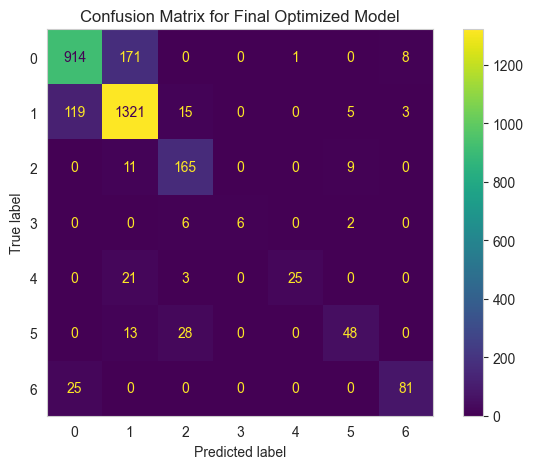

In [26]:
y_pred_test = final_model.predict(X_test)

# Calculate final accuracy
final_accuracy = accuracy_score(y_test, y_pred_test)

print("--- Performance Comparison ---")
# Assuming baseline_accuracy variable holds the score from Step 5
print(f"Baseline Accuracy (on Test Set): {baseline_accuracy * 100:.2f}%")
print(f"Optimized Accuracy (on Test Set): {final_accuracy * 100:.2f}%")
improvement = final_accuracy - baseline_accuracy
print(f"Improvement due to HPO: {improvement * 100:.2f}%")

print("Confusion Matrix for Final Optimized Model (on Test Set):")
ConfusionMatrixDisplay.from_estimator(final_model, X_test, y_test)
plt.title('Confusion Matrix for Final Optimized Model')
plt.tight_layout()
plt.grid(False)
plt.show()

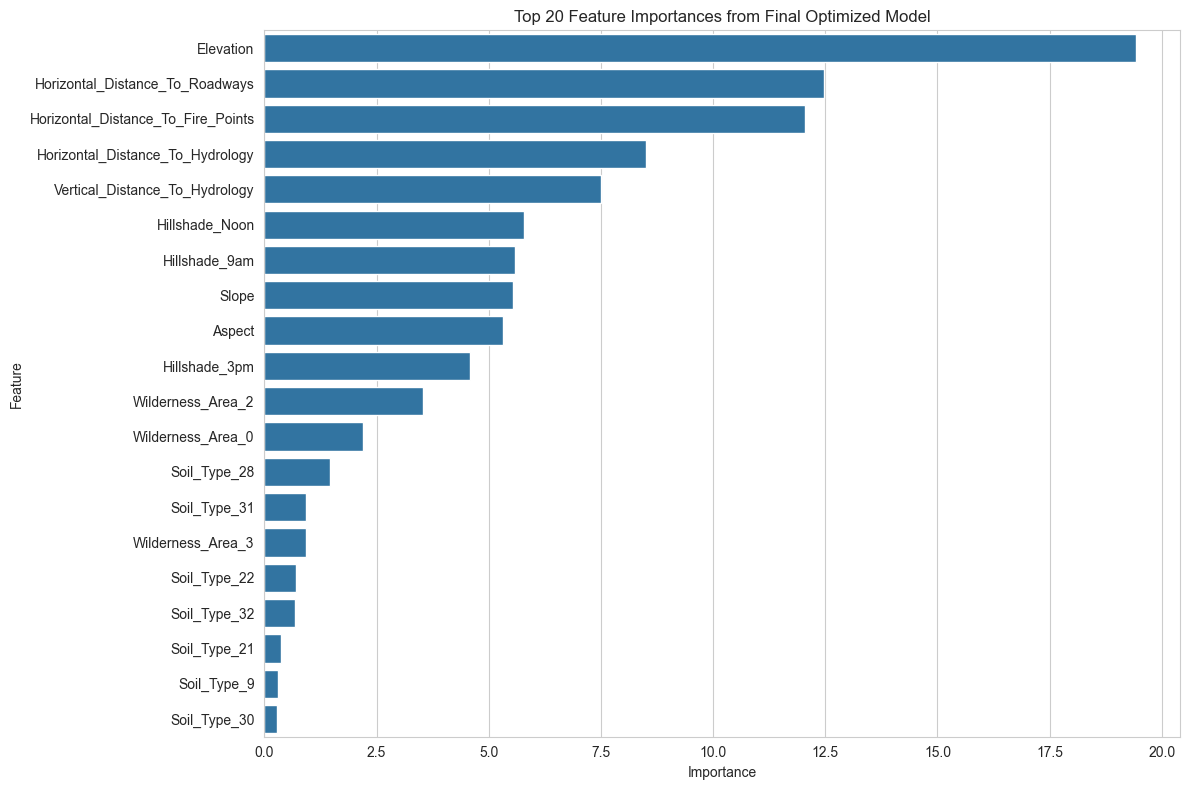

In [27]:
importances = final_model.get_feature_importance()
feature_names = X_train_full.columns

# Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances (e.g., top 20)
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(20)) # Plot top 20
plt.title('Top 20 Feature Importances from Final Optimized Model')
plt.tight_layout()
plt.show()